In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray
import tensorflow as tf
import tensorflow.keras.backend as K
import enso

In [2]:
np.random.seed(0)

## Extracting SST, ONI and Anomaly

In [3]:
signals = ['pna', 'ea', 'wa', 'wp', 'eu', 'soi', 'esoi', 'nino12', 'nino34', 'nino4']
signal_length = 6000
n_signals = 11

datapath = 'CM4_ctrl_indices.nc'

all_signals_nc = xarray.open_dataset(datapath, decode_times = False)
all_signals = np.zeros((signal_length, 1))

for signal in signals:
    new_signal = (all_signals_nc[signal].values).reshape((signal_length, 1))
    all_signals = np.append(all_signals, new_signal, axis = 1)
    
nino34 = all_signals_nc['nino34'].values
clm = enso.climatology(nino34)
anm = enso.anomaly(nino34, clm)
oni = enso.ONI(anm)
time = np.arange(anm.shape[0])

## Converting Time Series to Train/Validation/Test Datasets and Labels

We first decide how far into the future we aim to predict (T months into the future), how much history we use to do so (H months of past values information Hmax into the past), and number of extra features (means of previous months).

In [4]:
T = 12
H = 48

# One Signal

We then decide which time series to use for training (input_signal) and which time series to predict (output_signal):

In [5]:
input_signal = np.array(oni).copy()
input_signal = np.reshape(input_signal, (signal_length, 1))

output_signal = np.array(oni).copy()

We then normalize the input and output signals for more reliable performance:

In [6]:
input_signal = enso.normalize(input_signal)
output_signal = enso.normalize(output_signal)

Now we can create: (1) the feature matrix, i.e. the data to be used to predict the future time series value, and (2) the desired label vector.

In [7]:
data = enso.ts2history(input_signal, T, H)
data = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))

labels = enso.ts2diff(output_signal, T, H)
to_add = enso.ts2remainder(output_signal, T, H)
reconstructed = labels + to_add
time2D = enso.time2time2D(time, T, H)

We will use the first 80% of the time series as training data, the following 10% as validation and the last 10% for testing:

In [8]:
(test_start, test_end) = (6, 7)
(val_start, val_end) = (4, 5)

(train, test) = enso.split(data, test_start, test_end)
(train_labels, test_labels) = enso.split(labels, test_start, test_end)
(train_to_add, test_to_add) = enso.split(to_add, test_start, test_end)
(train_reconstructed, test_reconstructed) = enso.split(reconstructed, test_start, test_end)
(train_time2D, test_time2D) = enso.split(time2D, test_start, test_end)

(train, val) = enso.split(train, val_start, val_end)
(train_labels, val_labels) = enso.split(train_labels, val_start, val_end)
(train_to_add, val_to_add) = enso.split(train_to_add, val_start, val_end)
(train_reconstructed, val_reconstructed) = enso.split(train_reconstructed, val_start, val_end)
(train_time2D, val_time2D) = enso.split(train_time2D, val_start, val_end)

(Optional) Shuffle Training Data

In [9]:
shuffle = np.random.permutation(train.shape[0])
train = train[shuffle]
train_labels = train_labels[shuffle]
train_to_add = train_to_add[shuffle]
train_reconstructed = train_reconstructed[shuffle]

# Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression

## Learning Optimal Weights for all t simulatously:

In [11]:
cumulative_model = LinearRegression().fit(train, train_labels)
cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add
LR_mult_val_pred_rmse_1signal = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
LR_mult_val_pred_corr_1signal = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

## Learning Optimal Weights for separate t values:

In [12]:
LR_val_pred_rmse_1signal = np.zeros(T)
LR_val_pred_corr_1signal = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

In [13]:
for t in range(T):
    
    individual_model = LinearRegression().fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    LR_val_pred_rmse_1signal[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    LR_val_pred_corr_1signal[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

# Support Vector Regressors with RBF kernel

In [14]:
from sklearn.svm import SVR

## Learning Optimal Weights for separetely for all t:

In [15]:
SVRrbf_val_pred_rmse_1signal = np.zeros(T)
SVRrbf_val_pred_corr_1signal = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

In [16]:
for t in range(T):
    
    individual_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1).fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    SVRrbf_val_pred_rmse_1signal[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    SVRrbf_val_pred_corr_1signal[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

# Decision Trees and Forests

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Learning Optimal Weights for all t simulatously:

### Decision Tree

In [18]:
cumulative_model = DecisionTreeRegressor(max_depth = 5, random_state = 0).fit(train, train_labels)
cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add
DT_mult_val_pred_rmse_1signal = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
DT_mult_val_pred_corr_1signal = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

### Random Forest

In [19]:
cumulative_model = RandomForestRegressor(max_depth = 5, random_state = 0, n_estimators = 100).fit(train, train_labels)
cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add
RF_mult_val_pred_rmse_1signal = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
RF_mult_val_pred_corr_1signal = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

### Extra Trees

In [20]:
cumulative_model = ExtraTreesRegressor(max_depth = 5, random_state = 0, n_estimators = 100).fit(train, train_labels)
cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add
ET_mult_val_pred_rmse_1signal = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
ET_mult_val_pred_corr_1signal = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

## Learning Optimal Weights for all t separately:

### Decision Tree

In [21]:
DT_val_pred_rmse_1signal = np.zeros(T)
DT_val_pred_corr_1signal = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

In [22]:
for t in range(T):
    
    individual_model = DecisionTreeRegressor(max_depth = 5, random_state = 0).fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    DT_val_pred_rmse_1signal[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    DT_val_pred_corr_1signal[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

### Random Forest

In [23]:
RF_val_pred_rmse_1signal = np.zeros(T)
RF_val_pred_corr_1signal = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

In [24]:
for t in range(T):
    
    individual_model = RandomForestRegressor(max_depth = 5, random_state = 0, n_estimators = 100).fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    RF_val_pred_rmse_1signal[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    RF_val_pred_corr_1signal[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

### Extra Trees

In [25]:
ET_val_pred_rmse_1signal = np.zeros(T)
ET_val_pred_corr_1signal = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

In [26]:
for t in range(T):
    
    individual_model = ExtraTreesRegressor(max_depth = 5, random_state = 0, n_estimators = 100).fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    ET_val_pred_rmse_1signal[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    ET_val_pred_corr_1signal[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

# All Signals

In [27]:
input_signals = np.array(all_signals).copy()
input_signals = enso.normalize(input_signals)

data = enso.ts2history(input_signals, T, H)
data = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))

(test_start, test_end) = (6, 7)
(val_start, val_end) = (4, 5)

(train, test) = enso.split(data, test_start, test_end)
(train, val) = enso.split(train, val_start, val_end)

train = train[shuffle]

### Linear Regression: Cumulative

In [28]:
cumulative_model = LinearRegression().fit(train, train_labels)
cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add
LR_mult_val_pred_rmse = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
LR_mult_val_pred_corr = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

### Linear Regression: Individual

In [29]:
LR_val_pred_rmse = np.zeros(T)
LR_val_pred_corr = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

for t in range(T):
    
    individual_model = LinearRegression().fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    LR_val_pred_rmse[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    LR_val_pred_corr[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

### SVR with RBF kernel: Individual

In [30]:
SVRrbf_val_pred_rmse = np.zeros(T)
SVRrbf_val_pred_corr = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

for t in range(T):
    
    individual_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1).fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    SVRrbf_val_pred_rmse[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    SVRrbf_val_pred_corr[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

### Decision Tree: Cumulative

In [31]:
cumulative_model = DecisionTreeRegressor(max_depth = 5, random_state = 0).fit(train, train_labels)
cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add
DT_mult_val_pred_rmse = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
DT_mult_val_pred_corr = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

### Decision Tree: Individual

In [32]:
DT_val_pred_rmse = np.zeros(T)
DT_val_pred_corr = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

for t in range(T):
    
    individual_model = DecisionTreeRegressor(max_depth = 5, random_state = 0).fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    DT_val_pred_rmse[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    DT_val_pred_corr[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

### Random Forest: Cumulative

In [33]:
cumulative_model = RandomForestRegressor(max_depth = 5, random_state = 0, n_estimators = 100).fit(train, train_labels)
cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add
RF_mult_val_pred_rmse = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
RF_mult_val_pred_corr = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

### Random Forest: Individual

In [ ]:
RF_val_pred_rmse = np.zeros(T)
RF_val_pred_corr = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

for t in range(T):
    
    individual_model = RandomForestRegressor(max_depth = 5, random_state = 0, n_estimators = 100).fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    RF_val_pred_rmse[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    RF_val_pred_corr[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

### Extra Trees: Cumulative

In [48]:
cumulative_model = ExtraTreesRegressor(max_depth = 5, random_state = 0, n_estimators = 100).fit(train, train_labels)
cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add
ET_mult_val_pred_rmse = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
ET_mult_val_pred_corr = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

### Extra Trees: Individual

In [ ]:
ET_val_pred_rmse = np.zeros(T)
ET_val_pred_corr = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

for t in range(T):
    
    individual_model = ExtraTreesRegressor(max_depth = 5, random_state = 0, n_estimators = 100).fit(train, train_labels[:, t])
    
    individual_val_pred[t] = individual_model.predict(val).flatten() 
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]

    ET_val_pred_rmse[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    ET_val_pred_corr[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

# RESULTS

In [35]:
(persistance_corr, persistance_rmse) = enso.persistance_corr_rmse(oni, T)

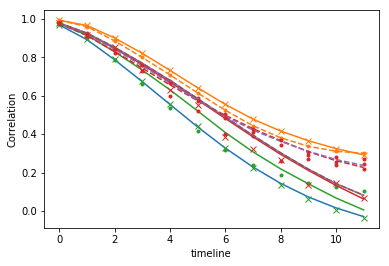

<Figure size 432x288 with 0 Axes>

In [50]:
plt.plot(persistance_corr, label = "Persistance");

plt.plot(LR_mult_val_pred_corr, label = "Linear Regression: Cumulative");
plt.plot(LR_val_pred_corr, 'C1x', label = "Linear Regression: Individual");
plt.plot(LR_mult_val_pred_corr_1signal, 'C1--', label = "Linear Regression: Cumulative (1 signal)");
plt.plot(LR_val_pred_corr_1signal, 'C1.', label = "Linear Regression: Individual (1 signal)");

plt.plot(SVRrbf_val_pred_corr, 'C2x', label = "SVR: Individual");
plt.plot(SVRrbf_val_pred_corr_1signal, 'C2.', label = "SVR: Individual (1 signal)");

plt.plot(DT_mult_val_pred_corr, label = "Decision Tree: Cumulative");
plt.plot(DT_val_pred_corr, 'C3x', label = "Decision Tree: Individual");
plt.plot(DT_mult_val_pred_corr_1signal, 'C3--', label = "Decision Tree: Cumulative (1 signal)");
plt.plot(DT_val_pred_corr_1signal, 'C3.', label = "Decision Tree: Individual (1 signal)");

plt.plot(RF_mult_val_pred_corr, label = "Random Forest: Cumulative");
#plt.plot(RF_val_pred_corr, 'C4x', label = "Random Forest: Individual");
plt.plot(RF_mult_val_pred_corr_1signal, 'C4--', label = "Random Forest: Cumulative (1 signal)");
plt.plot(RF_val_pred_corr_1signal, 'C3.', label = "Decision Tree: Individual (1 signal)");

plt.plot(ET_mult_val_pred_corr, label = "Extra Trees: Cumulative");
#plt.plot(ET_val_pred_corr, 'C4x', label = "Random Forest: Individual");
plt.plot(ET_mult_val_pred_corr_1signal, 'C5--', label = "Extra Trees: Cumulative (1 signal)");
plt.plot(ET_val_pred_corr_1signal, 'C3.', label = "Decision Tree: Individual (1 signal)");

plt.ylabel('Correlation');
plt.xlabel('timeline');
#plt.legend();
plt.figure();

#plt.plot(persistance_rmse, label = "Persistance");
#plt.ylabel('RMSE');
#plt.xlabel('timeline');
#plt.legend();